In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import special
from collections import defaultdict
import matplotlib
from calc_ece import get_metrics
from scipy.special import softmax

In [2]:
base_dirs = glob('model_scores/steamshp_xl/shp/word_perturb/*')
#base_dirs = glob('model_scores/steamshp_xl/open_ai_summarize_from_feedback/word_perturb/*')
base_dirs

['model_scores/steamshp_xl/shp/word_perturb/trial12',
 'model_scores/steamshp_xl/shp/word_perturb/trial10',
 'model_scores/steamshp_xl/shp/word_perturb/trial13']

In [3]:
def energy_score(logits, temperature=1.0):
    assert logits.shape[1] == 2
    # implements energy based out of distribution detection
    return (-temperature) * special.logsumexp(logits / temperature, axis=1)
    #return -temperature * (np.log(np.exp(logits / temperature).sum(axis=1)))

def msp_score(logits):
    assert logits.shape[1] == 2
    # implements maximum softmax probability based out of distribution detection
    return -1 * np.max(softmax(logits, axis=1), axis=1)

In [4]:
def calc_tnr(id_test_ood_scores, ood_test_ood_scores):
    scores = np.concatenate((id_test_ood_scores, ood_test_ood_scores))
    trues = np.array(([0] * len(id_test_ood_scores)) + ([1] * len(ood_test_ood_scores)))
    fpr, tpr, thresholds = roc_curve(trues, scores)
    return 1 - fpr[np.argmax(tpr>=.95)]

def calc_auroc(id_test_ood_scores, ood_test_ood_scores):
    #calculate the AUROC
    scores = np.concatenate((id_test_ood_scores, ood_test_ood_scores))
    trues = np.array(([0] * len(id_test_ood_scores)) + ([1] * len(ood_test_ood_scores)))
    result = roc_auc_score(trues, scores)

    return result

In [5]:
def calc_ece_acc(logits):
  scores = softmax(logits, axis=1)
  y_true = np.array([0] * len(scores)) # chosen is always class 0
  preds = scores.argmax(axis=1)
  confs = scores[np.arange(len(scores)), preds]
  ece, mce, acc = get_metrics(y_true=y_true, preds=preds, confs=confs)
  return ece, acc, confs

In [6]:
instances = [ 'prompt_and_response', 'prompt', 'response']

In [7]:
per_trial_auroc, per_trial_fpr = {inst: defaultdict(list) for inst in instances}, {inst: defaultdict(list) for inst in instances}
per_trial_acc, per_trial_ece, per_trial_conf = {inst: defaultdict(list) for inst in instances}, {inst: defaultdict(list) for inst in instances}, {inst: defaultdict(list) for inst in instances}
for base_dir in base_dirs:
    for inst in instances:
        perturbed_logits = {}
        for f in glob(f'{base_dir}/{inst}/*'):
            df = pd.read_csv(f)
            perturbation = float(os.path.basename(f).split('_')[0][:2]) / 10
            perturbed_logits[perturbation] = df.values

        
        energy_scores = {}
        for perturbation, logits in perturbed_logits.items():
            ece, acc, conf = calc_ece_acc(logits)
            per_trial_acc[inst][perturbation].append(acc)
            per_trial_ece[inst][perturbation].append(ece)
            per_trial_conf[inst][perturbation].append(conf.mean())

            energy_scores[perturbation] = energy_score(logits)

        id_test_ood_scores = energy_scores[0.0]
        for perturbation in sorted(energy_scores):
            ood_test_ood_scores = energy_scores[perturbation]
            auroc = calc_auroc(id_test_ood_scores, ood_test_ood_scores)
            tnrATtpr95 = calc_tnr(id_test_ood_scores, ood_test_ood_scores)
            per_trial_auroc[inst][perturbation].append(auroc)
            per_trial_fpr[inst][perturbation].append(1 - tnrATtpr95)

In [8]:
fpr_avg_inst, fpr_error_inst = {}, {}
auroc_avg_inst, auroc_error_inst = {}, {}
acc_avg_inst, acc_error_inst = {}, {}
ece_avg_inst, ece_error_inst = {}, {}
conf_avg_inst, conf_error_inst = {}, {}
for inst in instances:
    fpr_avg, fpr_error = {}, {}
    auroc_avg, auroc_error = {}, {}
    acc_avg, acc_error = {}, {}
    ece_avg, ece_error = {}, {}
    conf_avg, conf_error = {}, {}
    
    fprs = per_trial_fpr[inst]
    aurocs = per_trial_auroc[inst]
    accs = per_trial_acc[inst]
    eces = per_trial_ece[inst]
    confs = per_trial_conf[inst]
    for perturbation, val in fprs.items():
        fpr_avg[perturbation] = np.mean(val)
        fpr_error[perturbation] = 2*np.std(val)
        #fpr_error[perturbation] = abs(val[0] - val[1])
    for perturbation, val in aurocs.items():
        auroc_avg[perturbation] = np.mean(val)
        auroc_error[perturbation] = 2*np.std(val)
        #auroc_error[perturbation] = abs(val[0] - val[1])
    for perturbation, val in accs.items():
        acc_avg[perturbation] = np.mean(val)
        acc_error[perturbation] = 2*np.std(val)
    for perturbation, val in eces.items():
        ece_avg[perturbation] = np.mean(val)
        ece_error[perturbation] = 2*np.std(val)
    for perturbation, val in confs.items():
        conf_avg[perturbation] = np.mean(val)
        conf_error[perturbation] = 2*np.std(val)
    fpr_avg_inst[inst] = fpr_avg
    fpr_error_inst[inst] = fpr_error
    auroc_avg_inst[inst] = auroc_avg
    auroc_error_inst[inst] = auroc_error
    acc_avg_inst[inst] = acc_avg
    acc_error_inst[inst] = acc_error
    ece_avg_inst[inst] = ece_avg
    ece_error_inst[inst] = ece_error
    conf_avg_inst[inst] = conf_avg
    conf_error_inst[inst] = conf_error

In [9]:
perturbations = sorted(fpr_avg_inst['prompt_and_response'].keys())
perturbations

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [10]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'   : 56}
matplotlib.rc('font', **font)

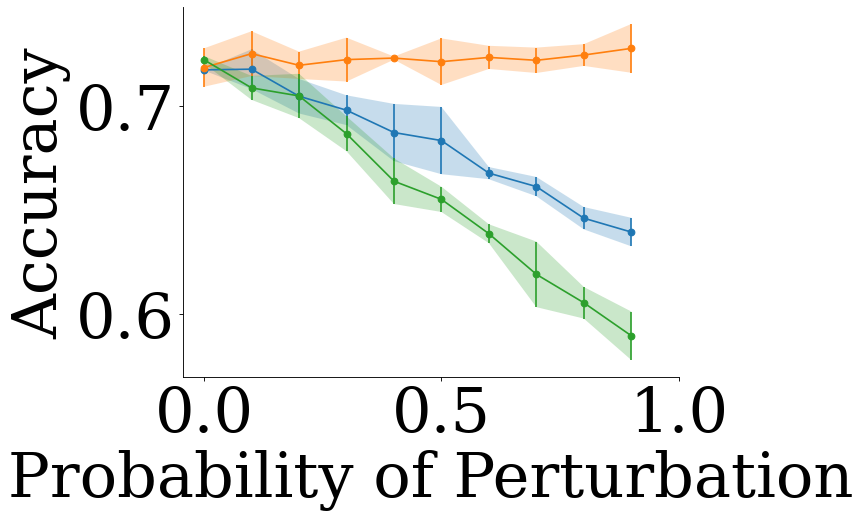

In [11]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(perturbations, [acc_avg_inst[inst][x] for x in perturbations], yerr =[acc_error_inst[inst][x] for x in perturbations], marker='o', label=inst.replace('_', ' '))
    upper_error = [acc_avg_inst[inst][x] + acc_error_inst[inst][x] for x in perturbations]
    lower_error = [acc_avg_inst[inst][x] - acc_error_inst[inst][x] for x in perturbations]
    plt.fill_between(perturbations, upper_error, lower_error, alpha=0.25)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.5))
plt.ylabel('Accuracy')

#plt.title('OOD Detection w Energy - FPR')
#plt.legend(prop={'size': 36}, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines[['right', 'top']].set_visible(False)

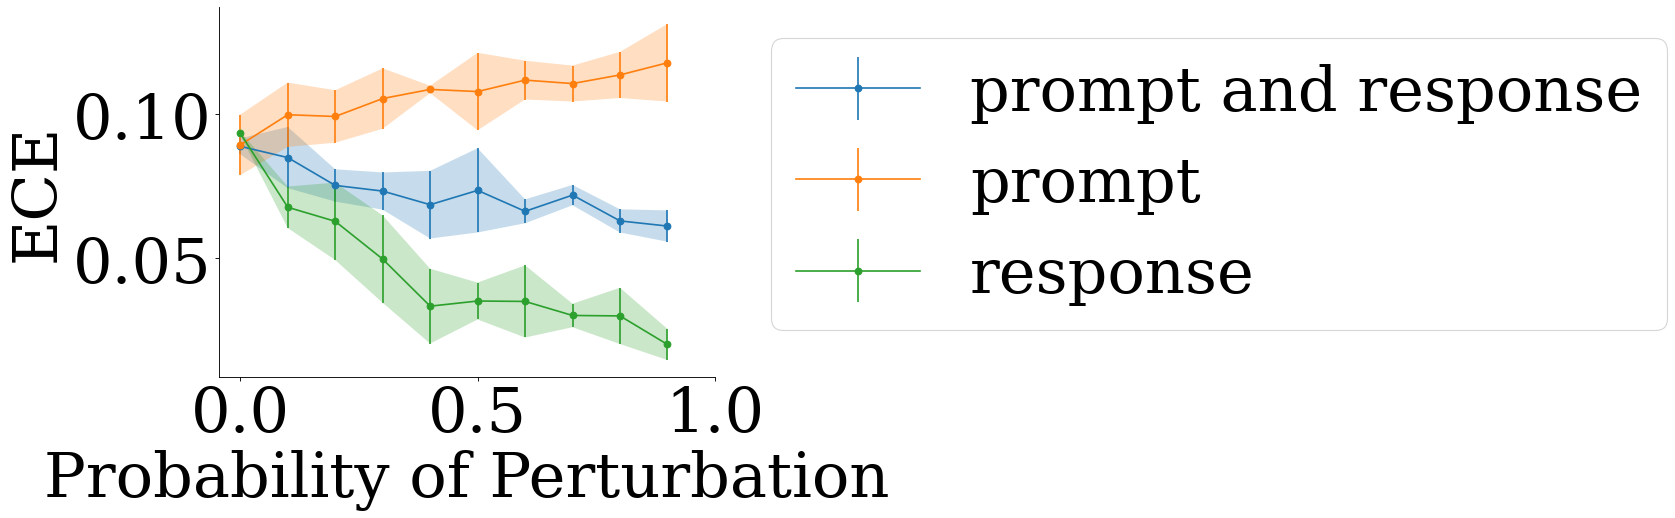

In [12]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(perturbations, [ece_avg_inst[inst][x] for x in perturbations], yerr =[ece_error_inst[inst][x] for x in perturbations], marker='o', label=inst.replace('_', ' '))
    upper_error = [ece_avg_inst[inst][x] + ece_error_inst[inst][x] for x in perturbations]
    lower_error = [ece_avg_inst[inst][x] - ece_error_inst[inst][x] for x in perturbations]
    plt.fill_between(perturbations, upper_error, lower_error, alpha=0.25)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.5))
plt.ylabel('ECE')
#plt.title('OOD Detection w Energy - FPR')
plt.legend(prop={'size': 56}, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines[['right', 'top']].set_visible(False)

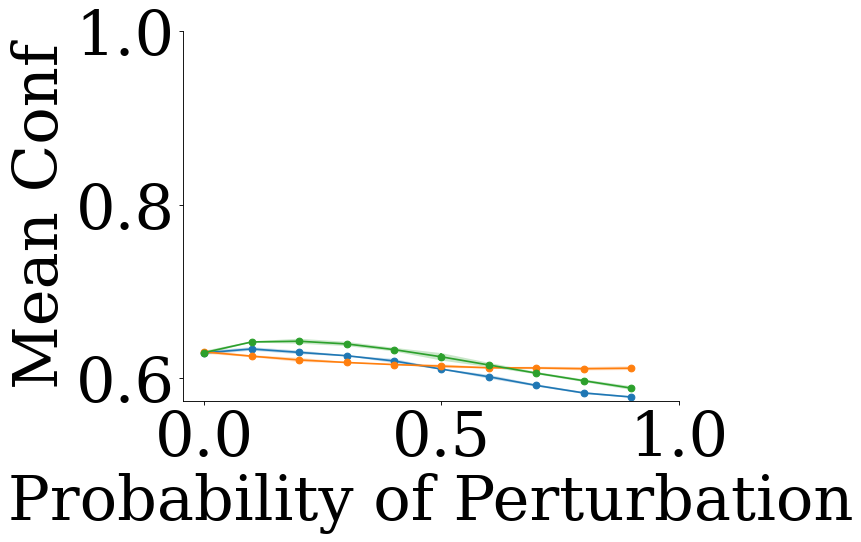

In [13]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(perturbations, [conf_avg_inst[inst][x] for x in perturbations], yerr =[conf_error_inst[inst][x] for x in perturbations], marker='o', label=inst.replace('_', ' '))
    upper_error = [conf_avg_inst[inst][x] + conf_error_inst[inst][x] for x in perturbations]
    lower_error = [conf_avg_inst[inst][x] - conf_error_inst[inst][x] for x in perturbations]
    plt.fill_between(perturbations, upper_error, lower_error, alpha=0.25)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.5))
plt.yticks([0.6, 0.8, 1.0])
plt.ylabel('Mean Conf')
#plt.title('OOD Detection w Energy - FPR')
#plt.legend(prop={'size': 36}, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines[['right', 'top']].set_visible(False)
#ax.yaxis.set_label_coords(-0.25,0.65)

In [14]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'   : 27}
matplotlib.rc('font', **font)

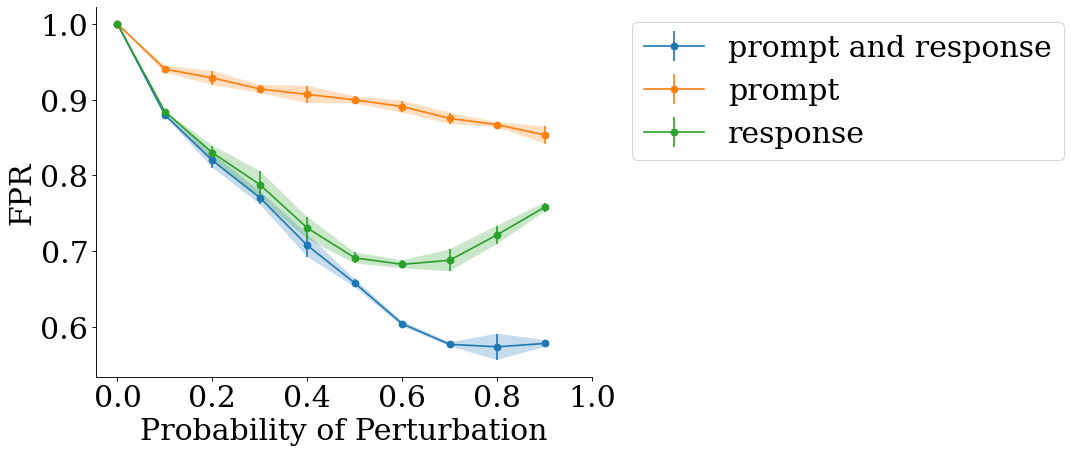

In [15]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(perturbations, [fpr_avg_inst[inst][x] for x in perturbations], yerr =[fpr_error_inst[inst][x] for x in perturbations], marker='o', label=inst.replace('_', ' '))
    upper_error = [fpr_avg_inst[inst][x] + fpr_error_inst[inst][x] for x in perturbations]
    lower_error = [fpr_avg_inst[inst][x] - fpr_error_inst[inst][x] for x in perturbations]
    plt.fill_between(perturbations, upper_error, lower_error, alpha=0.25)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.2))
plt.ylabel('FPR')
#plt.title('OOD Detection w Energy - FPR')
plt.legend(prop={'size': 27}, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines[['right', 'top']].set_visible(False)

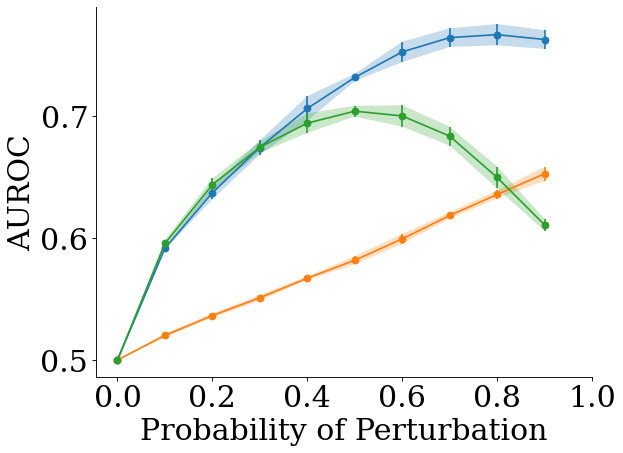

In [16]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(perturbations, [auroc_avg_inst[inst][x] for x in perturbations], yerr =[auroc_error_inst[inst][x] for x in perturbations], marker='o', label=inst.replace('_', ' '))
    upper_error = [auroc_avg_inst[inst][x] + auroc_error_inst[inst][x] for x in perturbations]
    lower_error = [auroc_avg_inst[inst][x] - auroc_error_inst[inst][x] for x in perturbations]
    plt.fill_between(perturbations, upper_error, lower_error, alpha=0.25)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.2))
plt.ylabel('AUROC')
#plt.title('OOD Detection w Energy - FPR')
#plt.legend(prop={'size': 36}, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines[['right', 'top']].set_visible(False)

MSP

In [17]:
instances = [ 'prompt_and_response', 'prompt', 'response',]
per_trial_auroc, per_trial_fpr = {inst: defaultdict(list) for inst in instances}, {inst: defaultdict(list) for inst in instances}
per_trial_acc, per_trial_ece, per_trial_conf = {inst: defaultdict(list) for inst in instances}, {inst: defaultdict(list) for inst in instances}, {inst: defaultdict(list) for inst in instances}
for base_dir in base_dirs:
    for inst in instances:
        perturbed_logits = {}
        for f in glob(f'{base_dir}/{inst}/*'):
            df = pd.read_csv(f)
            perturbation = float(os.path.basename(f).split('_')[0][:2]) / 10
            perturbed_logits[perturbation] = df.values

        
        msp_scores = {}
        for perturbation, logits in perturbed_logits.items():
            msp_scores[perturbation] = msp_score(logits)

        id_test_ood_scores = msp_scores[0.0]
        for perturbation in sorted(msp_scores):
            ood_test_ood_scores = msp_scores[perturbation]
            auroc = calc_auroc(id_test_ood_scores, ood_test_ood_scores)
            tnrATtpr95 = calc_tnr(id_test_ood_scores, ood_test_ood_scores)
            per_trial_auroc[inst][perturbation].append(auroc)
            per_trial_fpr[inst][perturbation].append(1 - tnrATtpr95)

In [18]:
fpr_avg_inst, fpr_error_inst = {}, {}
auroc_avg_inst, auroc_error_inst = {}, {}
for inst in instances:
    fpr_avg, fpr_error = {}, {}
    auroc_avg, auroc_error = {}, {}
    
    fprs = per_trial_fpr[inst]
    aurocs = per_trial_auroc[inst]
    for perturbation, val in fprs.items():
        fpr_avg[perturbation] = np.mean(val)
        fpr_error[perturbation] = 2*np.std(val)
        #fpr_error[perturbation] = abs(val[0] - val[1])
    for perturbation, val in aurocs.items():
        auroc_avg[perturbation] = np.mean(val)
        auroc_error[perturbation] = 2*np.std(val)
        #auroc_error[perturbation] = abs(val[0] - val[1])
    fpr_avg_inst[inst] = fpr_avg
    fpr_error_inst[inst] = fpr_error
    auroc_avg_inst[inst] = auroc_avg
    auroc_error_inst[inst] = auroc_error

In [19]:
perturbations = sorted(fpr_avg_inst['prompt_and_response'].keys())
perturbations

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

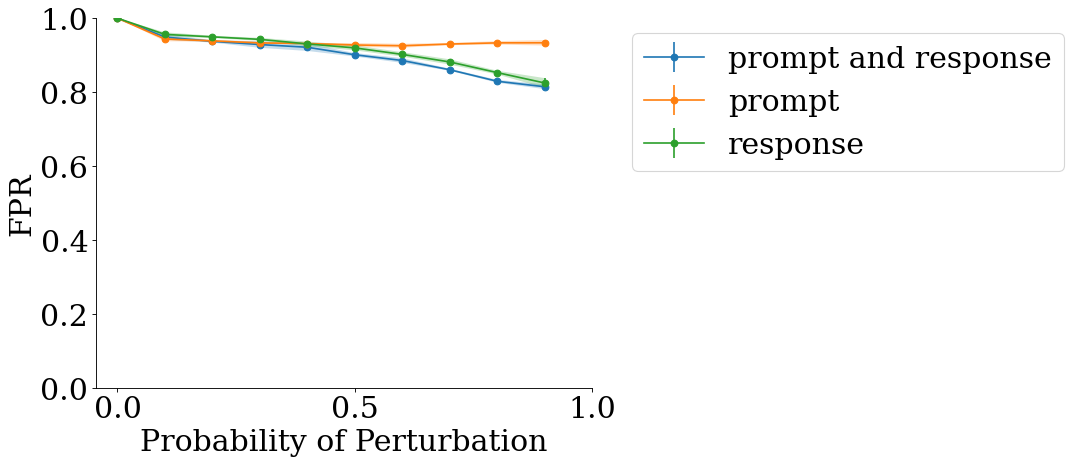

In [20]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(perturbations, [fpr_avg_inst[inst][x] for x in perturbations], yerr =[fpr_error_inst[inst][x] for x in perturbations], marker='o', label=inst.replace('_', ' '))
    upper_error = [fpr_avg_inst[inst][x] + fpr_error_inst[inst][x] for x in perturbations]
    lower_error = [fpr_avg_inst[inst][x] - fpr_error_inst[inst][x] for x in perturbations]
    plt.fill_between(perturbations, upper_error, lower_error, alpha=0.25)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.21, step=0.5))
plt.ylim(0,1)
plt.ylabel('FPR')
#plt.title('OOD Detection w Energy - FPR')
plt.legend(prop={'size': 27}, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines[['right', 'top']].set_visible(False)

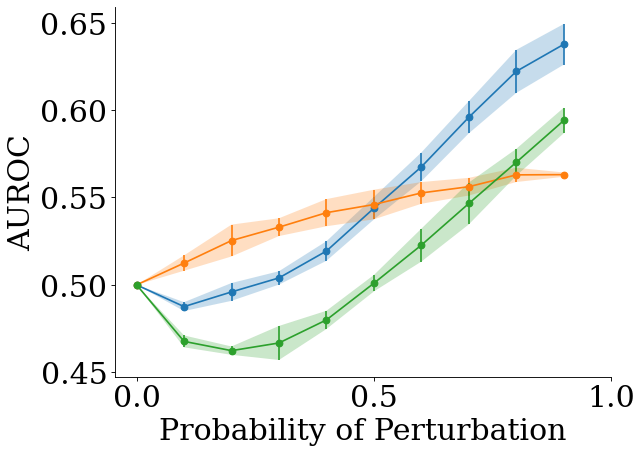

In [21]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(perturbations, [auroc_avg_inst[inst][x] for x in perturbations], yerr =[auroc_error_inst[inst][x] for x in perturbations], marker='o', label=inst.replace('_', ' '))
    upper_error = [auroc_avg_inst[inst][x] + auroc_error_inst[inst][x] for x in perturbations]
    lower_error = [auroc_avg_inst[inst][x] - auroc_error_inst[inst][x] for x in perturbations]
    plt.fill_between(perturbations, upper_error, lower_error, alpha=0.25)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.5))
plt.ylabel('AUROC')
#plt.title('OOD Detection w Energy - FPR')
#plt.legend(prop={'size': 36}, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines[['right', 'top']].set_visible(False)